# Project 1: Content Moderation and Toxicity Classification

## Pretrained Encoder-Transformers

#### Imports

In [8]:
import numpy as np
import pandas as pd
#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from pathlib import Path
import zipfile

## Data Preprocessing
### Data Source and Loading
In this phase of the project, we focus on preparing our data for analysis and model training. Data preprocessing is a critical step in any machine learning pipeline, as it ensures that our data is in the right format and is accessible for processing by our models.

In [9]:
# Importing the warnings module to handle warnings
import warnings
warnings.filterwarnings('ignore')

# Mount the drive and load the dataset
from google.colab import drive
drive.mount('/content/drive')

# Defining the path to the dataset stored in Google Drive.
data_path = Path('/content/drive/MyDrive/Colab Notebooks/Sentiment Data/data.zip')

# Defining the folder path where the extracted data will be stored.
folder_path = Path('my_data/')

# Checking if the folder already exists
if folder_path.is_dir():
  print("Directory already exists!")
else:
  # If the directory does not exist, create it.
  print("Making Directory")
  folder_path.mkdir(parents = True, exist_ok = True)

# Unzipping the data
  with zipfile.ZipFile(data_path, "r") as my_zip:
    print("Unzipping...")

    # Extracting the data
    my_zip.extractall(folder_path)
    print("All Done")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory already exists!


## Visualization of Data Distribution
To better understand the dataset, we explore the distribution of labels within our comments. This helps us identify imbalances and provides insights that can guide our preprocessing and model training strategies.

The following visualization shows the number of occurrences for each type of label in our training data:

### Code Description:
- We load our dataset from a CSV file into a pandas DataFrame.
- We then focus on the distribution of different labels which might represent various categories of toxicity such as 'toxic', 'severe_toxic', 'obscene', etc.
- By calculating the sum of each label and sorting them, we prepare our data for visualization.
- Using `matplotlib` and `seaborn`, we create a horizontal bar plot that clearly shows the frequency of each label.
- The plot is styled with a 'viridis' color palette for visual appeal and clarity.
- Finally, we display the plot with appropriate labels and a title.

The head of the dataset, showing a few sample entries, is printed for a quick glimpse into the data structure:

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  


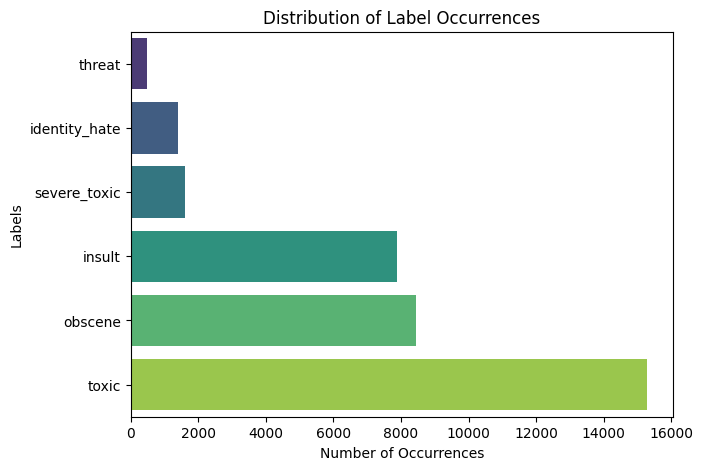

In [10]:
data = pd.read_csv("/content/my_data/train.csv")
print(data.head())

# Visualizing the class distribution of the 'label' column
column_labels = data.columns.tolist()[2:]
label_counts = data[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
                 y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()

# Data Cleaning and Sampling

This step refines the dataset for training, ensuring the model learns from balanced and relevant data to improve its accuracy and reliability.

## Steps Undertaken:

1. **Label Summarization**: We compute the sum of instances for each label within our dataset. This gives us an overview of the distribution of different classifications such as 'toxic', 'severe_toxic', etc.

2. **Separation of Data**: We categorize our comments into two groups:
   - **Toxic Comments**: Any comment tagged with at least one 'toxic' label.
   - **Clean Comments**: Comments without any 'toxic' labels.

3. **Sampling Clean Comments**: To balance our dataset, we randomly sample a subset of the clean comments. This step is crucial to prevent model bias towards the more frequent class.

4. **Merging Datasets**: We combine the toxic comments with the sampled clean comments to create a unified dataset ready for model training.

5. **Shuffling**: The combined dataset is then shuffled to ensure that the order of data does not introduce any bias during the training process.

6. **Splitting Data**: Finally, we extract the comment texts and labels from our dataset. We also create a validation set by splitting the data, which is used to evaluate the model's performance during training.

Through these steps, we ensure that our dataset is clean, balanced, and randomized, setting the stage for effective model training. This meticulous process aids in developing robust models that generalize well to unseen data.

In [11]:
# Summing up the values of each column specified in column_labels and then sorting them.
data[column_labels].sum().sort_values()

# the comment is tagged with at least one toxic label.
train_toxic = data[data[column_labels].sum(axis=1) > 0]
# has no toxic labels and is clean.
train_clean = data[data[column_labels].sum(axis=1) == 0]

# Randomly sample 15,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
dataframe = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
dataframe = dataframe.sample(frac=1, random_state=42)

# Extracting the 'comment_text' column as training texts
train_texts = dataframe['comment_text']
train_labels = dataframe.iloc[:,2:]

# validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.5, random_state=42)


# Tokenization and Encoding
## BERT Tokenizer
When preparing text data for Natural Language Processing (NLP) models, especially ones based on the Transformer architecture like BERT, the process begins with tokenization and encoding.

Tokenization splits the raw text into tokens (words or subwords), and encoding converts these tokens into numerical IDs that the model can understand. Special tokens like `[CLS]` for the start of the sequence and `[SEP]` for the end are added. Texts are also padded to a uniform length (`max_length`) or truncated if they're too long.

An attention mask is generated to tell the model which tokens should be paid attention to and which are padding. This preprocessed data is then fed into the BERT model for training or inference.

The following infographic illustrates this tokenization and encoding journey:

### Implementation in Code:
In our code:
- We define a `tokenize_and_encode` function to handle the conversion of text to tensors that BERT can process.
- We initialize a BERT tokenizer and model, ensuring all text is lowercased (`do_lower_case=True`) for consistency.
- The model is transferred to the appropriate device (GPU for faster processing, if available).
- Finally, we output the device being used to confirm where the computations will occur.

Through this preparation, our text data is ready for the model to learn from or to make predictions with.


In [12]:
def tokenize_and_encode(tokenizer, comments, labels, max_length=128):
    # Initialize empty lists to store tokenized inputs and attention masks
    input_ids = []
    attention_masks = []

    # Iterate through each comment in the 'comments' list
    for comment in comments:

        # Tokenize and encode the comment using the BERT tokenizer
        encoded_dict = tokenizer.encode_plus(
            comment,

            # Add special tokens like [CLS] and [SEP]
            add_special_tokens=True,

            # Truncate or pad the comment to 'max_length'
            max_length=max_length,

            # Pad the comment to 'max_length' with zeros if needed
            pad_to_max_length=True,

            # Return attention mask to mask padded tokens
            return_attention_mask=True,

            # Return PyTorch tensors
            return_tensors='pt'
        )

        # Append the tokenized input and attention mask to their respective lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Concatenate the tokenized inputs and attention masks into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Convert the labels to a PyTorch tensor with the data type float32
    labels = torch.tensor(labels, dtype=torch.float32)

    # Return the tokenized inputs, attention masks, and labels as PyTorch tensors
    return input_ids, attention_masks, labels


# Token Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels=6)

device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)
print(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


# Text Preparation for BERT

In Natural Language Processing (NLP), text data must be converted into a numerical format that a model can interpret. **BERT**, a transformer-based machine learning model for NLP tasks, requires a specific format for input data which includes tokenization and encoding.

## Tokenization and Encoding Explained

The process begins with **tokenization**, where text is split into smaller pieces, or "tokens." Each token corresponds to a word or subword in the text. BERT uses a WordPiece algorithm that allows it to handle a wide range of vocabulary without storing an enormous word-index.

**Encoding** involves translating each token into a unique integer ID from BERT's vocabulary. This step is crucial as it converts text into data that can be processed by the model's neural network layers.

Additionally, since BERT processes data in batches, all input sequences must be of the same length. We achieve this through **padding** (adding zeros to shorter sequences) and **truncation** (cutting off tokens from longer sequences).

We also generate **attention masks** to let the model differentiate between content and padding. This mask indicates which tokens are words and should be focused on versus which ones are padding and should be ignored.

## Implementing in Code

Here's how we implement these steps in our code:

- We call `tokenize_and_encode` to tokenize the comments and convert them to BERT's expected input format.
- We use `TensorDataset` to wrap our input IDs, attention masks, and labels into a dataset that's easy to iterate over during training.
- `DataLoader` objects are then created to handle shuffling and batching of our dataset, ensuring that our model can efficiently learn from the data.

The outcome of this preprocessing is a set of tensors that represent our text data, ready for training or evaluating our BERT model.


In [13]:
# Tokenize and encode the training texts and labels.
# This function converts the text data into a format that is suitable for input to BERT model.
# It includes converting texts into tokens, mapping these tokens to their index in the tokenizer vocabulary,
# and creating attention masks to indicate which tokens should be attended to by the model.
input_ids, attention_masks, labels = tokenize_and_encode(
    tokenizer,
    train_texts,
    train_labels.values
)

# Tokenize and Encode the comments and labels for the validation set
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(
    tokenizer,
    val_texts,
    val_labels.values
)

# Output the shape of the training data
print('Training Comments :',train_texts.shape)
print('Input Ids         :',input_ids.shape)
print('Attention Mask    :',attention_masks.shape)
print('Labels            :',labels.shape)

# Creating DataLoader for the balanced dataset
batch_size = 32
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# validation set
# Creating a DataLoader for the validation set.
val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Training Comments : (16225,)
Input Ids         : torch.Size([16225, 128])
Attention Mask    : torch.Size([16225, 128])
Labels            : torch.Size([16225, 6])


# Training Preparation
## Dataset and DataLoader

Before diving into the actual model training, we must establish a solid foundation by initializing our training environment and data handling mechanisms.

### Optimizer Initialization
We choose the AdamW optimizer for its improved weight decay handling over the standard Adam optimizer. Weight decay is a regularization technique to prevent overfitting by penalizing large weights. The learning rate is set to `2e-5`, a common choice for fine-tuning BERT models.

### Training Function
The `train_model` function is the core of our training loop. Here's what happens inside it:

- **Epochs**: We iterate over the number of epochs specified.
- **Loss Initialization**: We start with a total loss of zero for each epoch, suming the loss as we process batches.
- **Batch Processing**: For each batch in our DataLoader, we:
  - Move our data (`input_ids`, `attention_masks`, and `labels`) to the active device (GPU for acceleration ).
  - Clear previous gradients, perform a forward pass to get predictions and loss, and then a backward pass to calculate gradients.
  - Update model parameters with `optimizer.step()`.
- **Validation**: After training on all batches, we switch the model to evaluation mode and calculate the validation loss without updating model parameters. This gives us a measure of how well our model is generalizing.

### Running the Training
With the `train_model` function defined, we call it with our model, DataLoader, optimizer, device, and the number of epochs. The training process involves both learning from the training data and periodically validating against the validation data to monitor the model's performance.

By the end of these steps, our model will have learned to predict from our data, and we will have a clear picture of its training and validation loss, guiding us towards fine-tuning or further improvements.

In [14]:
# Initializing the optimizer.
# AdamW is a variant of the Adam optimizer with fixed weight decay.
optimizer = AdamW(model.parameters(), lr=2e-5)


# function to train the model.
def train_model(model, train_loader, optimizer, device, num_epochs):
    # Loop through the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to training mode
        model.train()
        # Initialize total loss for the current epoch
        total_loss = 0
        i=0

        # Loop through the batches in the training data
        print(len(train_loader))
        for batch in train_loader:
            # using GPU or CPU
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Clearing out the gradients of the optimizer. Gradients need to be cleared to prevent double-counting in subsequent backpropagation.
            optimizer.zero_grad()

# Forward pass: Computing the predicted outputs by passing inputs to the model.
            outputs = model(
                input_ids, attention_mask=attention_mask, labels=labels)
            # Extracting the loss from the model's output.
            loss = outputs.loss
            # adding loss over all batches to calculate the total loss for the epoch.
            total_loss += loss.item()
            # Backward pass
            loss.backward()
            # Updating the model parameters based on the current gradient.
            optimizer.step()
            if(i%100 == 0):
              print(i)
            i+=1

        model.eval()  # Set the model to evaluation mode
        val_loss = 0

        # Disable gradient computation during validation
        print(len(val_loader))
        j = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [
                    t.to(device) for t in batch]

                # Forward pass with the validation data.
                outputs = model(
                    input_ids, attention_mask=attention_mask, labels=labels)

                # getting the loss from the outputs and summing them
                loss = outputs.loss
                val_loss += loss.item()
                if(j%100 == 0):
                  print(j)
                j+=1
        # Print the average loss for the current epoch
        print(
            f'Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader)},Validation loss:{val_loss/len(val_loader)}')


# Call the function to train the model
train_model(model, train_loader, optimizer, device, num_epochs=3)

508
0
100
200
300
400
500
508
0
100
200
300
400
500
Epoch 1, Training Loss: 0.2169283077003449,Validation loss:0.16485132914087844
508
0
100
200
300
400
500
508
0
100
200
300
400
500
Epoch 2, Training Loss: 0.1431237730952933,Validation loss:0.15244671082817107
508
0
100
200
300
400
500
508
0
100
200
300
400
500
Epoch 3, Training Loss: 0.11806991795356583,Validation loss:0.16281816167674415


# Model Evaluation
## Evaluation Metrics

After training our model, it's crucial to assess its performance using a set of evaluation metrics. This step helps us understand the effectiveness of our model in making predictions.

### The Evaluation Function
We define the `evaluate_model` function to systematically evaluate our trained model on the test data. Here's what the function does:

- It switches the model to evaluation mode, which is essential for accurate performance measurement.
- We loop through the test data, computing predictions for each batch.
- The model's output logits are passed through a sigmoid function to obtain probabilities, which are then converted to binary predictions based on a 0.5 threshold.
- We concatenate all the predictions and true labels to calculate global metrics such as accuracy, precision, and recall.
- These metrics give us a quantitative measure of our model's performance:
  - **Accuracy**: The proportion of correct predictions over the total number of cases evaluated.
  - **Precision**: The ratio of true positive predictions to the total positive predictions.
  - **Recall**: The ability of the model to find all the relevant cases within the dataset.

By running `evaluate_model`, we receive immediate feedback on our model's performance, which is printed out for further analysis and reporting.

In [15]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    true_labels = []
    predicted_probs = []

    # Disabling gradient calculations for efficiency. Gradients are not needed during evaluation.
    with torch.no_grad():
        # Loop through each batch in the test data loader.
        for batch in test_loader:
            # GPU or CPU
            input_ids, attention_mask, labels = [t.to(device) for t in batch]

            # Forward pass: Compute the predicted outputs by passing the batch through the model.
            outputs = model(input_ids, attention_mask=attention_mask)

            # Use sigmoid for multilabel classification (probabilities)
            predicted_probs_batch = torch.sigmoid(outputs.logits)

            # from GPU to CPU
            predicted_probs.append(predicted_probs_batch.cpu().numpy())

            true_labels_batch = labels.cpu().numpy()
            true_labels.append(true_labels_batch)

    # Combine predictions and labels for evaluation
    true_labels = np.concatenate(true_labels, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)

     # Convert probabilities to binary predictions using a threshold of 0.5.
    predicted_labels = (predicted_probs > 0.5).astype(
        int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='micro')
    recall = recall_score(true_labels, predicted_labels, average='micro')
    f1 = f1_score(true_labels, predicted_labels, average='micro')

    # Print the evaluation metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')


# Call the function to evaluate the model on the test data
# evaluate_model(model, test_loader, device)

# Saving and Loading Model
## Saving Process

Once we have trained our model to satisfaction, the next crucial step is to save our model and tokenizer. This allows us to reload the model later to make predictions without having to retrain it from scratch, which is essential for deploying our model into a production environment or for further analysis.

### How We Save the Model and Tokenizer

- **Model Saving**: We save the model's weights and configuration. This includes all the parameters that have been learned during training.
- **Tokenizer Saving**: The tokenizer is also saved, including its vocabulary and any special tokens specific to BERT.
- Both the model and tokenizer are saved in the `Saved_model` directory. This ensures that all related files are organized and easily accessible.

In [16]:
# Save the tokenizer and model in the same directory
output_dir = "Saved_model"
# Save model's state dictionary and configuration
model.save_pretrained(output_dir)
# Save tokenizer's configuration and vocabulary
tokenizer.save_pretrained(output_dir)

('Saved_model/tokenizer_config.json',
 'Saved_model/special_tokens_map.json',
 'Saved_model/vocab.txt',
 'Saved_model/added_tokens.json')

# Loading Process

After saving our trained model and tokenizer, we need to be able to load them back into our working environment. This allows us to continue working with our model, whether for further training, evaluation, or making new predictions.

### Steps for Loading the Model and Tokenizer

- **Loading the Tokenizer**: We load the BERT tokenizer from the directory where we saved it. This ensures we have the exact tokenization scheme that was used during training.
- **Loading the Model**: Similarly, we load the BERT model for sequence classification from the same directory. This model contains the weights and configuration from our training process.

In [17]:

# Load the tokenizer and model from the saved directory

# using GPU or CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the tokenizer and model from the saved directory
model_name = "/content/Saved_model"

# Loading the BERT model for sequence classification from the saved directory.
Bert_Tokenizer = BertTokenizer.from_pretrained(model_name)
Bert_Model = BertForSequenceClassification.from_pretrained(
    model_name).to(device)

# Ensuring that the model is assigned to the correct device.
Bert_Model = Bert_Model.to(device)
print(device)

cuda


# Inference and Prediction
## Prediction Function

In this section, we focus on using our trained BERT model to make predictions on new, unseen data. This process, known as inference, is crucial for evaluating how our model will perform in real-world scenarios.

### The Prediction Function Explained

- **Function Definition**: We define a function `predict_user_input` that takes in a text input, the model, tokenizer, and device (GPU or CPU) to perform the prediction.
- **Tokenization**: The input text is tokenized in the same way as our training data, ensuring consistency in data format.
- **Data Preparation**: We wrap the tokenized inputs into a `TensorDataset` and create a `DataLoader` for it. This allows us to process the input in a format that our model expects.
- **Model Evaluation**: We set the model to evaluation mode and disable gradient calculations for efficiency.
- **Prediction**: The model predicts the probabilities of each label for the input text. These probabilities are then converted to binary labels using a threshold of 0.5.
- **Result Presentation**: The predictions are mapped to their corresponding label names, resulting in a dictionary that shows the likelihood of each label being applicable to the input text.

In [18]:
def predict_user_input(input_text, model=Bert_Model, tokenizer=Bert_Tokenizer, device=device):
    # Wrap the input text in a list. The tokenizer expects a list of texts.
    user_input = [input_text]

    # Tokenize the user input. This includes converting the text to tokens,
    # truncating it to the maximum length the model can handle, and padding shorter texts.
    # 'return_tensors="pt"' tells the tokenizer to return PyTorch tensors.
    user_encodings = tokenizer(
        user_input, truncation=True, padding=True, return_tensors="pt")

    # TensorDataset wraps tensors into a dataset and is used here to create a compatible format for DataLoader.
    user_dataset = TensorDataset(
        user_encodings['input_ids'], user_encodings['attention_mask'])

    # DataLoader is used to create an iterable over the dataset with a specified batch size.
    # Since we are predicting for a single input, batch_size is set to 1.
    user_loader = DataLoader(user_dataset, batch_size=1, shuffle=False)

    # Set the model to evaluation mode.
    model.eval()

    with torch.no_grad():
        for batch in user_loader:
            # GPUT or CPU
            input_ids, attention_mask = [t.to(device) for t in batch]

            # Get model's predictions for the batch.
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Apply sigmoid function to the output logits to obtain probabilities.
            predictions = torch.sigmoid(logits)

    # Convert the predictions to binary labels using a threshold (0.5)
    predicted_labels = (predictions.cpu().numpy() > 0.5).astype(int)

    # Define a list of label names corresponding to the outputs.
    labels_list = ['toxic', 'severe_toxic', 'obscene',
                   'threat', 'insult', 'identity_hate']

        # Create a dictionary mapping label names to their predicted values.
    result = dict(zip(labels_list, predicted_labels[0]))
    return result

# examples
text = 'Are you insane!'
predict_user_input(input_text=text)

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 0,
 'threat': 0,
 'insult': 1,
 'identity_hate': 0}

In [19]:
predict_user_input(input_text='I will kill you nigga')

{'toxic': 1,
 'severe_toxic': 0,
 'obscene': 1,
 'threat': 1,
 'insult': 1,
 'identity_hate': 1}

# Reading and Filtering Test Data

The final step in preparing our dataset involves reading the test data and ensuring it's in the correct format for model evaluation.

## Reading Test Data
First, we read our test data and its corresponding labels from CSV files. This data is crucial for objectively assessing the performance of our trained model.

### Filtering the Test Labels
Not all rows in the test data might be relevant or properly labeled. We specifically filter out rows where the 'toxic' column has a value of `-1`, which likely indicates missing or irrelevant data. This step ensures that we only consider rows with proper labels for evaluation.

### Matching Test Data and Labels
We then align the test data (`test_texts`) with the filtered labels (`test_labels`). This alignment is crucial to maintain the correspondence between the input texts and their respective labels, a vital aspect for accurate model evaluation.

In [20]:
# Reading Test data from the csv files
test_data = pd.read_csv("/content/my_data/test.csv")
test_labels = pd.read_csv("/content/my_data/test_labels.csv")

# Filtering the test labels   to exclude rows where the 'toxic' column has a value of -1.
# The value -1 in this context likely indicates missing or irrelevant data
test_labels = test_labels[test_labels['toxic'] != -1]

# Selecting the rows in 'test_data' that have corresponding labels in 'test_labels'.
test_texts = test_data[test_data['id'].isin(test_labels['id'])]

# Preparing Test Data for BERT
After filtering and aligning our test data, the next step is to prepare it for evaluation using the BERT model. This involves tokenizing and encoding the data in a format that BERT can understand and process.

## Tokenization and Encoding Process
The tokenization and encoding are handled by the `tokenize_and_encode` function, which performs several critical steps:

1. **Tokenization with BertTokenizer**:
   - The `BertTokenizer` instance converts the raw text data into tokens. Tokenization is the process of breaking down text into smaller pieces that the model can work with.

2. **Processing Text Data**:
   - We process the text data (`comment_text`) from our `test_texts` DataFrame. This text is what we need our model to evaluate.

3. **Handling Labels**:
   - The labels associated with our test data are also prepared. We use `iloc[:,1:].values` to select all rows but only columns with labels, converting them into a NumPy array for easy handling.

In [21]:
# Tokenize and encode the test dataset using the BERT tokenizer.
# This is a crucial step to prepare the textual data for processing by the BERT model.
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(
    tokenizer,
    test_texts['comment_text'],
    test_labels.iloc[:,1:].values
)

# Tokenizing and encoding the test data using BERT tokenizer.

# 'tokenize_and_encode' is used with:
# 1. tokenizer: BertTokenizer instance for text conversion.
# 2. test_texts['comment_text']: Text data from the test dataset.
# 3. test_labels.iloc[:,1:].values: Corresponding labels for the test data as a NumPy array.

# Preparing Test Data for Model Evaluation
Once the test dataset has been tokenized and encoded, it's crucial to set it up in a way that's compatible with our BERT model for evaluation. This involves creating a `TensorDataset` and a `DataLoader`.

## Creating TensorDataset
A `TensorDataset` wraps the tokenized and encoded data (`test_input_ids`, `test_attention_masks`, and `test_labels`) into a single dataset. This format is particularly useful for PyTorch models, as it allows for easy batching and access during the evaluation process.

## DataLoader Setup
The `DataLoader` is responsible for feeding this data to our model during evaluation. Key points in its setup include:

- **Batch Size**: We choose a batch size of 32, meaning the model will process 32 examples at a time. This number is a balance between memory usage and performance.
- **Shuffling**: For the test set, we set `shuffle=False` to maintain the order of the data. This is important for evaluation purposes, as we want to compare our predictions directly with the actual labels.

In [22]:
# Prepare the test data for the model.
# This combines the test text, attention masks, and labels into a single dataset.
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Set up for loading the test data.
# DataLoader helps to go through the test data in small groups (batches) of 32 at a time,
# without mixing up the order of the data.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Evaluation

After training and preparing our model, it's essential to evaluate its performance to understand how well it has learned to predict the desired outcomes.

## Evaluating the Trained Model
We use the `evaluate_model` function to assess the model's effectiveness. This function will put the model through its paces with the test data and provide us with key performance metrics.

### Key Metrics for Evaluation
The function evaluates the model on various metrics, such as:

- **Accuracy**: Measures the proportion of correct predictions.
- **Precision and Recall**: Evaluate the model's ability to correctly identify positive instances and its sensitivity to detecting positive labels, respectively.

These metrics give us a quantifiable understanding of how well our model performs and are crucial for gauging its effectiveness in real-world applications.

In [23]:
print("Trained Model Stats =")
# Use the 'evaluate_model' function to check how well the trained model is doing.
# It will test the model with the test data and show results like accuracy and other scores.
evaluate_model(model, test_loader, device)

# print("Loaded Model Stats =")
# evaluate_model(Bert_Model, test_loader, device)

Trained Model Stats =
Accuracy: 0.7483
Precision: 0.3987
Recall: 0.8829
F1 Score: 0.5493
